# Forming Queries with Rasters
Querying the database with rasters is essentially the same as with the other two tables. A primary difference however is they are returned as a [rasterio dataset](https://rasterio.readthedocs.io/en/stable/api/rasterio.io.html#rasterio.io.DatasetReader) instead of a dataframe.
   
## Grab a whole raster. 
Grabbing whole rasters can be done (albeit with caution) using the `from_filter` function. 

**Note**: snowexsql will throw an error if you try to pull more than one dataset at a time. This is because this function is merging tiles together based on the query and if the dataset grids dont match the database throws a cryptic error. So we took the liberty ahead of time. 

**Try this** : To see the error in action, remove the date from the query and run it. 


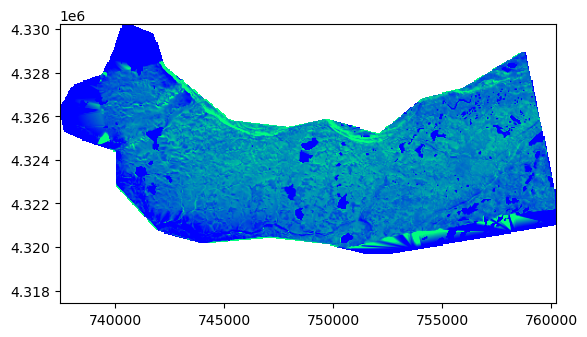

(50.000101089121436, 50.000101089121436)

In [46]:
# import in the raster measurments class
from snowexsql.api import RasterMeasurements
from datetime import datetime 

# Pick a date
dt = datetime(2020, 2, 13)

# Query db filtering to swe on a certain date surveyed by ASO
ds = RasterMeasurements.from_filter(observers='ASO Inc.', date=dt, type='swe')

# Plot it up!
show(ds[0], vmin=0.1, vmax=0.4, cmap='winter')

# Note the resolution!
ds[0].res


### Let's get part of raster dataset centered on a point

More reasonably, we often want chucks of rasters given an point or area of interest. Below is an example of how to do this off of a point. 

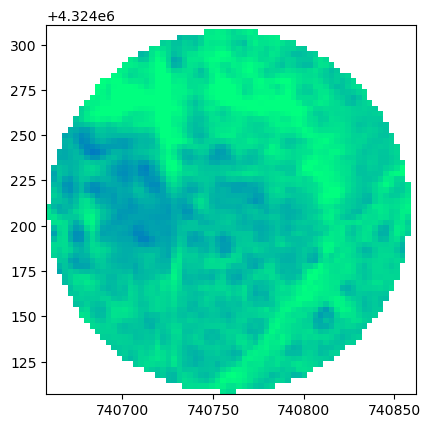

(3.000000000007304, 3.000000000007304)
[datetime.date(2020, 2, 2), datetime.date(2020, 2, 13)]


,depth,site_id,pit_id,bottom_depth,comments,sample_a,sample_b,sample_c,value,flags,...,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,observers
0,67.0,1N3,COGM1N3_20200211,57.0,None,None,None,None,242.5,None,...,2020-02-11,2024-08-15 19:24:19.860106+00:00,None,2308829,https://doi.org/10.5067/DUD2VZEVBJ7S,2022-06-30,None,density,None,None


In [1]:
# Import in the Raster and Layer measurement classes
from snowexsql.api import RasterMeasurements, LayerMeasurements
from datetime import date
from rasterio.plot import show

# Pick a site ID
site_id = '1N3'
df_site = LayerMeasurements.from_filter(site_id=site_id, limit=1)

# Grab available dates
dates = RasterMeasurements.from_unique_entries(["date"], observers='ASO Inc.', type='depth')

# Subset a raster on our buffered point!
ds = RasterMeasurements.from_area(pt=df_site.geometry[0], buffer=100, observers='ASO Inc.', type='depth', date=dates[0])

# Plot it up!
show(ds, vmin=0, vmax=1, cmap='winter')

# Note the resolution
print(ds.res)

# Show the site df and available dates. 
print(dates)

# Show off the location dataframe
df_site

In [48]:
# Demo a useful function from rasterio! 

# grab the xy as a tuple e.g. (x,y)
xy = (df_site.geometry[0].x,  df_site.geometry[0].y)

# Use the rasterio sample function and the grab the sample
sd = [s[0] for s in ds.sample([xy])][0]

# Print it out nice and neat!
print(f"Lidar snow depth = {sd:0.2f}m")


Lidar snow depth = 0.74m


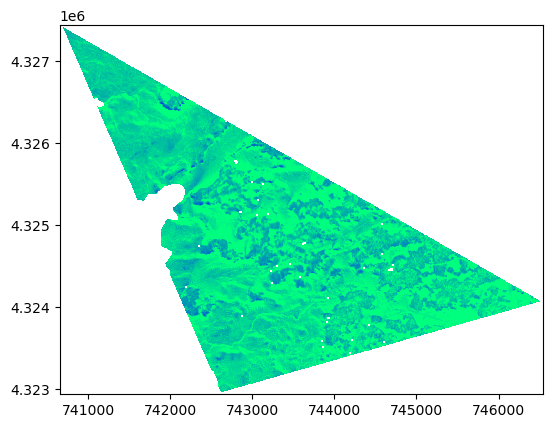

<Axes: >

In [49]:
from snowexsql.api import RasterMeasurements, LayerMeasurements
from shapely.geometry import Polygon
import geopandas as gpd


# Lets form a triangle using site IDs
site_id = ['2S6', '2C2', '8N45']

# Grab the unique locations for these 
locations = LayerMeasurements.from_unique_entries(['easting', 'northing'],
                                                site_id=site_id)

# Form a polygon object
triangle = Polygon(locations)

# Query the db for raster data in the triangle
ds = RasterMeasurements.from_area(shp=triangle, observers='ASO Inc.', type='depth',
                                  date=date(2020, 2, 2))
# plot it up!
show(ds, vmin=0, vmax=1, cmap='winter')

## Recap
Isolating raster datasets can enable users to build out workflows using only data of interest! No more downloading massive datasets (unless you want to!) 

**You should know something about**
* How `RasterMeasurements.from_*` differ from `PointMeasurements.from*` or `LayerMeasurements.from*`
* Raster with too coarse of filtering were error out due to too many datasets.
* Rasterio datasets offer a useful sample function for point extraction
